In [1]:
import cv2
import numpy as np
import scipy.ndimage
from pandas import DataFrame, concat
from math import sin, cos, radians
from decimal import Decimal, ROUND_HALF_UP
import pareto_GA as ga
import practice_evaluate_sampleple as es
import seaborn as sns

In [99]:
class evaluate_sample:
    def __init__(self, **kwargs):
        self.robot_path_1 = kwargs.get('robot_map','../robot_path/small_map_path_1.png')
        self.robot_path_2 = kwargs.get('robot_map','../robot_path/small_map_path_2.png')
        self.robot_path_3 = kwargs.get('robot_map','../robot_path/small_map_path_3.png')
        self.geomap = kwargs.get('geomap','../small_map.png')#実際に検証をするマップ
        
        self.urg_range = kwargs.get('urg_pix',400)#Lidarの測定範囲
        self.urg_resolution = kwargs.get('resolution', 10)#角度分解能
        self.rotation = kwargs.get('rotaion', 180)#回転角度     
        self.deg_list = np.arange(0.0, 181.0, self.urg_resolution)#角度分解能のlist
        self.range_list = None
        self.range_list_rotation = None
        
        #LiDARの最端座標
        self.x_fin = []
        self.y_fin = []
        self.x_fin_rotation = []
        self.y_fin_rotation = []
        
        #LiDARの分解能ごとの最近傍座標
        self.x_object = []
        self.y_object = []
        self.x_object_rotation = []
        self.y_object_rotation = []
        
        #初期位置だけ灰色の地図
        self.robot_map = None
        
        #幾何地図を1,0の配列で表現
        self.object_map = None
        
        #初期位置から障害物までの距離を格納
        self.distance_map = None

        self.robot_points = None
        self.original_geomap = None
        
        self.comparison_list = None
        self.comparison_list_rotation = None
        self.delta_list = None
        self.match_count = None

        self.initial_flag = False
        self.initial_flag_rotation = False
        
        self.path_dist = None
        

    #robot_points（経路）, object_mapを作成
    #output:全経路長
    def map_from_img(self):
        #robot_pathのグリッド毎の色情報を取得(黒が0だった)
        self.img_robo_path_1 = cv2.imread(self.robot_path_1)
        self.robot_map_1 = cv2.cvtColor(self.img_robo_path_1, cv2.COLOR_BGR2GRAY)
        self.img_robo_path_2 = cv2.imread(self.robot_path_2)
        self.robot_map_2 = cv2.cvtColor(self.img_robo_path_2, cv2.COLOR_BGR2GRAY)
        self.img_robo_path_3 = cv2.imread(self.robot_path_3)
        self.robot_map_3 = cv2.cvtColor(self.img_robo_path_3, cv2.COLOR_BGR2GRAY)
        
        #robot_pathの座標を取得[(縦, 横)，・・・]
        self.robot_points_1 = np.column_stack(np.where(self.robot_map_1 < 5))
        self.robot_points_2 = np.column_stack(np.where(self.robot_map_2 < 5))
        self.robot_points_3 = np.column_stack(np.where(self.robot_map_3 < 5))  
        self.robot_points = np.concatenate([self.robot_points_1, self.robot_points_2, self.robot_points_3])
        self.path_dist = int((len(self.robot_points))/3)
        
        #幾何地図を1,0で表現(黒を1に，白を0に)⇒object_map
        self.img_geomap = cv2.imread(self.geomap)
        self.original_geomap = cv2.cvtColor(self.img_geomap, cv2.COLOR_BGR2GRAY)
        self.object_map = np.where(self.original_geomap < 5, 1, 0)
        print(self.object_map.sum())
        print("robot_points_length = %d, 1path_dist = %d" % (len(self.robot_points),self.path_dist))
        return len(self.robot_points)
       
    def map_init_u(self, current_num=0):
        #0が並んだ地図を用意
        self.robot_map = self.robot_map_1
        self.robot_map[:,:] = 0
        
        #robot_mapの現地点を灰色に
        self.robot_map[self.robot_points[current_num][0], self.robot_points[current_num][1]] = 155
        
        #現地点から各グリッドまでの距離を格納した配列を生成
        self.distance_map = scipy.ndimage.morphology.distance_transform_edt(self.robot_map==0)        
        
    def urg_scan(self, current_num):
        #LiDARの各照射角度での最端座標の配列
        self.x_fin[:] = []
        self.y_fin[:] = []
        
        #(x, y) = (横，縦)　に
        original_x = self.robot_points[current_num][1]
        original_y = self.robot_points[current_num][0]

        #x,y_finに各照射角度の最端座標が格納(時計回りで90°〜-90°)
        for r in self.deg_list:
            x_ = self.urg_range * cos(radians(90-r))
            y_ = self.urg_range * sin(radians(90-r))
            x_ = Decimal(str(x_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            y_ = Decimal(str(y_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            x  = original_x + x_
            y  = original_y - y_
            self.x_fin.append(int(x))
            self.y_fin.append(int(y))
    
    def bresenham(self, current_num):
        self.x_object = []#total_num番目の基準点におけるLiDARが当たっている物体座標が格納される
        self.y_object = []
        self.range_list = []
    
        #現地点の座標をoriginal_x, yに格納
        original_x = self.robot_points[current_num][1]
        original_y = self.robot_points[current_num][0]

        for i in range(len(self.deg_list)):
            #現地点から現照射角度の最端座標をx, yに格納
            x = self.x_fin[i]
            y = self.y_fin[i]
            delta_x = abs(x - original_x) 
            delta_y = abs(y - original_y) 
            error = 0
            write_x = original_x
            write_y = original_y
            
            x1 = y - original_y + original_x
            x2 = original_y + original_x -y
            
            step1 = True if abs(y - original_y) < abs(x - original_x) else False
            step2 = True if original_y < y else False
            
            if step1 & step2:
                for write_x in range(original_x, x+1, 1):
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_y - delta_x
                        if error >= 0:#右上に進む(でなければ右に進む)
                            write_y += 1
                            error -= delta_x
                            
                        else:
                            error += delta_x
                 
            elif (not step1) & step2:
                new_x, new_y = original_x, original_y 
                for new_x in range(original_x, x1+1, 1):
                    write_x = new_y + original_x - original_y
                    write_y = new_x + original_y - original_x
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_x - delta_y
                        if error >= 0:#右上に進む(でなければ右に進む)
                            new_y += 1
                            error -= delta_y
                        
                        else:
                            error += delta_y

            elif step1 & (not step2):
                new_y = original_y
                for write_x in range(original_x, x+1, 1):
                    write_y = 2*original_y - new_y
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_y - delta_x
                        if error >= 0:#右上に進む(でなければ右に進む)
                            new_y += 1
                            error -= delta_x
                            
                        else:
                            error += delta_x
                            
            else:
                new_x, new_y = original_x, original_y 
                for new_x in range(original_x, x2+1, 1):
                    write_x = new_y + original_x - original_y
                    write_y = original_y + original_x - new_x

                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_x - delta_y
                        if error >= 0:
                            new_y += 1
                            error -= delta_y
                        
                        else:
                            error += delta_y
        
    def feature_df(self, current_num, total_num):
        
        if self.initial_flag == False:
            self.comparison_list = DataFrame(data=self.range_list, index=self.deg_list)#行でLiDARの照射角度、列で経路上の基準点を指定する、物体距離情報のデータフレーム_osanai
            self.initial_flag = True
        else:
            update_list = DataFrame(data=self.range_list, index=self.deg_list, columns=[current_num])
            self.comparison_list = concat([self.comparison_list, update_list], axis=1, sort=True)#もともとのやつと結合させる
                    
        comparison_bool = (self.comparison_list.iloc[:-1,:total_num] > 0.0)#dがあればTrue、0ならばFalseを格納
        self.comparison_list.loc['count'] = comparison_bool.sum()#それぞれのポイントでの物体座標数　データフレームにcount行を追加

    #df2numpy
    #距離情報とcountの行列を作成
    def similarity_init(self):
        tmp_frame = self.comparison_list.copy()
#         print(tmp_frame)
        tmp_frame.drop('count',axis=0,inplace=True)#count行を削除
#         try:
#             tmp_frame.drop('match',axis=0,inplace=True)
#         except:
#             pass
        
        self.comparison_count = self.comparison_list.loc['count'].to_numpy() #no pandas
        self.comparison_matrix = tmp_frame.to_numpy() # no need for pandas
#         print(self.comparison_count)
#         print(self.comparison_matrix)

        
        tmp_frame = self.comparison_list_rotation.copy()
        tmp_frame.drop('count',axis=0,inplace=True)
#         try:
#             tmp_frame.drop('match',axis=0,inplace=True)
#         except:
#             pass
        
        self.comparison_count_rotation = self.comparison_list_rotation.loc['count'].to_numpy() #no pandas
        self.comparison_matrix_rotation = tmp_frame.to_numpy() # no need for pandas

        
    def Urg_similarity(self, current_num, total_num):
        self.delta_list = self.comparison_list.copy()
        self.delta_list.drop('count', axis=0, inplace=True)#count行を削除
        for i in range(total_num):
            self.delta_list.iloc[:,i] = np.abs((self.comparison_list.iloc[:,i] - self.comparison_list[current_num]))#基準としたものとの差分　後ろの項が基準_osanai
        self.comparison_bool = (self.delta_list.iloc[:,:total_num] < 4.0)#基準との差が4？？より小さいところ(物体距離情報がマッチしているところ)_osanai
        self.comparison_bool2 = (self.comparison_list.iloc[:-1,:total_num] > 0.0)#物体距離情報があるところ(d=0ではないところ)_osanai
        self.comparison_bool3 = self.comparison_bool & self.comparison_bool2
        self.delta_list.loc['match'] = self.comparison_bool3.sum()#マッチしてる数_osanai
        #print(self.delta_list)
        match_count = self.delta_list.loc['match']
        ori_count = self.comparison_list.loc['count']
        rate = np.divide(match_count, ori_count, out=np.zeros_like(match_count), where=ori_count!=0)#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        #print(match_count, ori_count, rate)
        return rate

    def Urg_similarity_fast(self, current_num, total_num):
        delta_list = np.abs(self.comparison_matrix-self.comparison_matrix[:,[current_num]])
        comparison_bool = (delta_list[:,:total_num] < 4.0) & (self.comparison_matrix[:,:total_num] > 0.0)
        match_count = comparison_bool.sum(axis=0)
        rate = np.divide(match_count, self.comparison_count, where=self.comparison_count!=0, out=np.zeros_like(self.comparison_count))#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        return rate

    
    def Urg_similarity_fast_all(self):
        #ブロードキャスト演算
        #照射角度×全経路長×全経路長の三次元配列
        #参考サイト ⇒ https://qiita.com/ken_yoshi/items/4cbe3abb7d46c5252fdd
        delta_all = np.abs(self.comparison_matrix[:,:,None]-self.comparison_matrix[:,None,:])#ブロードキャスト演算
        
        #距離情報が一致する部分をカウント
        #照射角度×全経路長×全経路長、4grid分の幅
        comparison_bool = (delta_all < 4.0) & (self.comparison_matrix[:,:,None] > 0.0)
        
        #経路のグリッド毎に、距離情報が一致したものをカウント
        #全経路長×全経路長、対称行列
        match_count = comparison_bool.sum(axis=0)
        
        #類似度算出
        #分母=距離情報が得られた角度の総数
        #分子=一致したものの総数
        rate = np.divide(match_count, np.ones((match_count.shape[0],1))*self.comparison_count, 
                         where=np.ones((match_count.shape[0],1))*self.comparison_count!=0, #分母!=0の確認？
                         out=np.zeros(match_count.shape))#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        print(rate)
        print(rate.shape)
        return rate

    
    def urg_scan_rotation(self, current_num):
        self.x_fin_rotation[:] = []#Lidarそれぞれの最端座標
        self.y_fin_rotation[:] = []
        original_x = self.robot_points[current_num][1]#u座標　基準点
        original_y = self.robot_points[current_num][0]#v座標

        for r in self.deg_list:
            x_ = self.urg_range * cos(radians(90-(r-self.rotation)))#180°回転！！_osanai
            y_ = self.urg_range * sin(radians(90-(r-self.rotation)))#180°回転！！_osanai
            x_ = Decimal(str(x_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)#四捨五入
            y_ = Decimal(str(y_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            x  = original_x + x_
            y  = original_y - y_
            self.x_fin_rotation.append(int(x))
            self.y_fin_rotation.append(int(y))
       
    def bresenham_rotation(self, current_num):
        self.x_object_rotation = []#total_num番目の基準点におけるLiDARが当たっている物体座標が格納される
        self.y_object_rotation = []
        self.range_list_rotation = []
        
        for i in range(len(self.deg_list)):
            original_x = self.robot_points[current_num][1]#u座標　基準点
            original_y = self.robot_points[current_num][0]#v座標

            x = self.x_fin_rotation[i]
            y = self.y_fin_rotation[i]

            step = True if abs(y - original_y) > abs(x - original_x) else False 
            #print(step)

            if step:
                original_x, original_y = original_y, original_x 
                x, y = y, x

            delta_x = abs(x - original_x) 
            delta_y = abs(y - original_y) 
            error = int(delta_x / 2) 
            write_y = original_y 

            inc = 1 if original_x < x else -1 
            y_step = 1 if original_y < y else -1 

            for write_x in range(original_x, x+inc, inc):
                if step:
                    if self.object_map[write_x][write_y] == 1:
                        d = self.distance_map[write_x][write_y]
                        self.range_list_rotation.append(d)#距離情報をlistに追加
                        self.x_object_rotation.append(write_y)
                        self.y_object_rotation.append(write_x)
                        break
                    if write_x == x and write_y == y:
                        self.range_list_rotation.append(0.0)
                        self.x_object_rotation.append(y)
                        self.y_object_rotation.append(x)
                else:
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list_rotation.append(d)
                        self.x_object_rotation.append(write_x)
                        self.y_object_rotation.append(write_y)
                        break
                    if write_x == x and write_y == y:
                        self.range_list_rotation.append(0.0)
                        self.x_object_rotation.append(x)
                        self.y_object_rotation.append(y) 
                error = error - delta_y
                if error < 0:
                    write_y = write_y + y_step
                    error = error + delta_x
    
    def feature_df_rotation(self, current_num=0, total_num=0):
        if self.initial_flag_rotation == False:
            self.comparison_list_rotation = DataFrame(data=self.range_list_rotation, index=self.deg_list)
            self.initial_flag_rotation = True
        else:
            update_list = DataFrame(data=self.range_list_rotation, index=self.deg_list, columns=[current_num])
            self.comparison_list_rotation = concat([self.comparison_list_rotation, update_list], axis=1, sort=True)#もともとのやつと結合させる
        comparison_bool = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        self.comparison_list_rotation.loc['count'] = comparison_bool.sum()#それぞれのポイントでの物体座標数
    
    def Urg_similarity_rotation(self, current_num, total_num):
        self.delta_list_rotation = self.comparison_list.copy()
        self.delta_list_rotation.drop('count', axis=0, inplace=True)
        for i in range(total_num):
            self.delta_list_rotation.iloc[:,i] = np.abs((self.comparison_list.iloc[:,i] - self.comparison_list_rotation[current_num]))#基準としたものとの差分 0度と180度を比較_osanai
        self.comparison_bool_rotation = (self.delta_list_rotation.iloc[:,:total_num] < 4.0)
        #self.delta_list.loc['match'] = comparison_bool.sum() 
        self.comparison_bool2_rotation = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        self.comparison_bool3_rotation = self.comparison_bool_rotation & self.comparison_bool2_rotation
        self.delta_list_rotation.loc['match'] = self.comparison_bool3_rotation.sum()
      
        match_count_rotation = self.delta_list_rotation.loc['match']
        ori_count_rotation = self.comparison_list_rotation.loc['count']
        rate_rotation = np.divide(match_count_rotation, ori_count_rotation, out=np.zeros_like(match_count_rotation), where=ori_count_rotation!=0)
        return rate_rotation
    
    def Urg_similarity_rotation_fast(self, current_num, total_num):
        delta_list = np.abs(self.comparison_matrix-self.comparison_matrix_rotation[:,[current_num]])
        comparison_bool = (delta_list[:,:total_num] < 4.0) & (self.comparison_matrix_rotation[:,:total_num] > 0.0)
        match_count = comparison_bool.sum(axis=0)
        rate = np.divide(match_count, self.comparison_count_rotation, where=self.comparison_count_rotation!=0, out=np.zeros_like(self.comparison_count_rotation))#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        return rate
    
    def Urg_similarity_rotation_both(self, current_num, total_num):
        self.delta_list_rotation_both = self.comparison_list_rotation.copy()
        self.delta_list_rotation_both.drop('count', axis=0, inplace=True)
        for i in range(total_num):
            self.delta_list_rotation_both.iloc[:,i] = np.abs((self.comparison_list_rotation.iloc[:,i] - self.comparison_list_rotation[current_num]))
        comparison_bool_rotation_both = (self.delta_list_rotation_both.iloc[:,:total_num] < 4.0)
        #self.delta_list.loc['match'] = comparison_bool.sum() 
        comparison_bool2_rotation_both = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        comparison_bool3_rotation_both = comparison_bool_rotation_both & comparison_bool2_rotation_both
        self.delta_list_rotation_both.loc['match'] = comparison_bool3_rotation_both.sum()
      
        match_count_rotation_both = self.delta_list_rotation_both.loc['match']
        ori_count_rotation_both = self.comparison_list_rotation.loc['count']
        rate_rotation_both = np.divide(match_count_rotation_both, ori_count_rotation_both, out=np.zeros_like(match_count_rotation_both), where=ori_count_rotation_both!=0)
        return rate_rotation_both
    
    def Urg_similarity_rotation_both_fast(self, current_num, total_num):
        # comparison_list - comparison_list_rotation? seems odd
        delta_list = np.abs(self.comparison_matrix_rotation-self.comparison_matrix_rotation[:,[current_num]])
        comparison_bool = (delta_list[:,:total_num] < 4.0) & (self.comparison_matrix_rotation[:,:total_num] > 0.0)
        match_count = comparison_bool.sum(axis=0)
        rate = np.divide(match_count, self.comparison_count_rotation, where=self.comparison_count_rotation!=0, out=np.zeros_like(self.comparison_count_rotation))#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        return rate


In [100]:
#インスタンス生成
sample = evaluate_sample(urg_pix=20, geomap='../map/small_map.png')

In [101]:
#全経路長をcountに格納
count = sample.map_from_img()

93
robot_points_length = 18, 1path_dist = 6


In [102]:
#countの数だけ観測情報を算出
for e in range(count):
    sample.map_init_u(current_num=e)
    sample.urg_scan(current_num=e)
    sample.bresenham(current_num=e)
    sample.feature_df(current_num=e,total_num=count)
    sample.urg_scan_rotation(current_num=e)
    sample.bresenham_rotation(current_num=e)
    sample.feature_df_rotation(current_num=e,total_num=count)
print(sample.distance_map)

[[101.13851887 100.44899203  99.76472322 ...  77.83315489  78.18567644
   78.54934755]
 [100.41912169  99.72462083  99.03534723 ...  76.89603371  77.25283166
   77.62087348]
 [ 99.70456359  99.00505038  98.31073187 ...  75.96051606  76.32168761
   76.69419796]
 ...
 [ 74.          73.05477397  72.11102551 ...  36.12478374  36.87817783
   37.64306045]
 [ 74.33034374  73.38937253  72.44998275 ...  36.79673899  37.53664876
   38.28837944]
 [ 74.67261881  73.73601562  72.80109889 ...  37.48332963  38.20994635
   38.94868419]]


In [103]:
sample.similarity_init()

In [104]:
%%time
#resemblance = [sample.Urg_similarity_fast(current_num=d,total_num=count) for d in range(count)]
resemblance = sample.Urg_similarity_fast_all()
#print((np.sum(resemblance)-len(sample.robot_points))/2)

#resemblance_rotation      = [sample.Urg_similarity_rotation(current_num=d,total_num=count) for d in range(count)]
#resemblance_rotation      = [sample.Urg_similarity_rotation_fast(current_num=d,total_num=count) for d in range(count)]
#print(np.sum(resemblance_rotation))

#resemblance_rotation_both = [sample.Urg_similarity_rotation_both(current_num=d,total_num=count) for d in range(count)]
#resemblance_rotation_both = [sample.Urg_similarity_rotation_both_fast(current_num=d,total_num=count) for d in range(count)]
#print((np.sum(resemblance_rotation_both)-len(sample.robot_points))/2)


[[1.         0.66666667 0.44444444 0.11111111 0.         0.
  0.         0.14285714 0.4        0.44444444 0.66666667 0.33333333
  1.         0.66666667 0.66666667 0.33333333 0.         0.        ]
 [1.         1.         0.66666667 0.33333333 0.         0.
  0.         0.14285714 0.4        0.66666667 1.         1.
  1.         1.         1.         1.         0.         0.        ]
 [1.         1.         1.         0.66666667 0.5        0.
  1.         0.57142857 0.7        0.66666667 1.         1.
  1.         1.         1.         1.         0.         0.        ]
 [0.25       0.5        0.66666667 1.         1.         1.
  1.         0.85714286 0.7        0.66666667 0.5        1.
  0.25       0.5        0.5        1.         0.         0.        ]
 [0.         0.         0.33333333 0.66666667 1.         1.
  1.         0.85714286 0.6        0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0

In [919]:
replace = np.array(resemblance)#縦横0度同士path1~3_osanai
replace_rotation = np.array(resemblance_rotation)#縦180度，横0度path1~3_osanai
replace_rotation_both = np.array(resemblance_rotation_both)#縦横180度同士path1~3_osanai

In [920]:
%%time
#df1 = DataFrame(replace)
#df1_sum = df1.sum()
#df1_sum_sum = (df1_sum.sum()-len(sample.robot_points))/2#同じとこ除外(-類似度1*114)と、かぶってるとこ除外(÷２),要素数は(114*114)/2_osanai

#df1_sum_sum = (np.sum(replace)-len(sample.robot_points))/2

df2 = DataFrame(replace_rotation)
df2_sum = df2.sum()
df2_sum_sum = df2_sum.sum()#要素数は114*114_osanai
#df2_sum_sum = np.sum(replace_rotation)

df3 = DataFrame(replace_rotation_both)
df3_sum = df3.sum()
df3_sum_sum = (df3_sum.sum()-len(sample.robot_points))/2#同じとこ除外(-類似度1*114)と、かぶってるとこ除外(÷２),要素数は(114*114)/2_osanai
#df3_sum_sum = (np.sum(replace_rotation_both)-len(sample.robot_points))/2#同じとこ除外(-類似度1*114)と、かぶってるとこ除外(÷２),要素数は(114*114)/2_osanai

CPU times: user 1.02 ms, sys: 90 µs, total: 1.11 ms
Wall time: 1.02 ms


In [9]:
Nscore = (df1_sum_sum + df2_sum_sum + df3_sum_sum)/(len(sample.robot_points)*len(sample.robot_points)*2-len(sample.robot_points))#30*2C2(組み合わせ)_osanai
print(Nscore)

0.38792831947593853


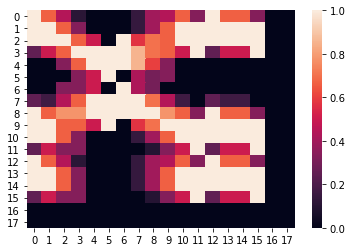

In [68]:
sns.heatmap(df1)

In [18]:
print(sample.deg_list)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]


In [19]:
print(sample.x_fin)

[70, 73, 77, 80, 83, 85, 87, 89, 90, 90, 90, 89, 87, 85, 83, 80, 77, 73, 70]


In [20]:
print(sample.y_fin)

[53, 53, 54, 56, 58, 60, 63, 66, 70, 73, 76, 80, 83, 86, 88, 90, 92, 93, 93]


In [21]:
print(sample.robot_points)

[[23 20]
 [23 30]
 [23 40]
 [23 50]
 [23 60]
 [23 70]
 [48 20]
 [48 30]
 [48 40]
 [48 50]
 [48 60]
 [48 70]
 [73 20]
 [73 30]
 [73 40]
 [73 50]
 [73 60]
 [73 70]]
